In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
from datetime import datetime as dt
import re
from math import nan
import requests
from bs4 import BeautifulSoup as Bs
from fake_useragent import UserAgent
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import geopy
from geopy.geocoders import Nominatim
from multiprocessing.dummy import Pool as ThreadPool
UserAgent().chrome

'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1500.55 Safari/537.36'

In [4]:
df = pd.read_csv('main_task.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

В датасете содержится только 3 числовых признака. Остальные 7 признаков
номинативные. Что в этих признаках посмотрим дальше. В некоторых признаках много пропусков, которые нужно будет как-то заполнить или сделать с ними ещё что-нибудь.

Корреляция между Ranking и id ресторана, имеет корреляционную зависимость, в будущем один из признаком нужно будет удалить, а пока что попытаемся понять, что здесь не так.

In [8]:
df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: float(x[3:]))

In [9]:
df[['Restaurant_id', 'Ranking']].corr()

,Restaurant_id,Ranking
Restaurant_id,1.0,1.0
Ranking,1.0,1.0


'City'

In [10]:
df.City.describe()

count      40000
unique        31
top       London
freq        5757
Name: City, dtype: object

У этого признака нет пропусков. Когда будем создавать новые признаки, сделаем из этого столбца pd.get_dummies()

'Number of Reviews'

In [11]:
df['Number of Reviews'].describe()

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [12]:
df['Number of Reviews'].isna().sum()

2543

В столбце есть пропуски. Вынесем все пропуски в отдельный признак. И заменим их на 0 в 'Number of Reviews'

In [13]:
df['Number of Reviews NAN'] = (pd.isna(df['Number of Reviews']).astype('uint8'))

In [14]:
df['Number of Reviews'].fillna(0, inplace = True)

Напишем функцию для поиска выбросов

In [15]:
def find_outliers(column):
    Q1,Q3 = df[column].quantile([.25,.75], interpolation="midpoint")
    IQR = Q3-Q1
    return [Q1-1.5*IQR,Q3+1.5*IQR]

Посмотрим сколько значений выходит за верхнюю границу

In [16]:
upper_outlier = find_outliers('Number of Reviews')[1]
sum(df['Number of Reviews']>upper_outlier)

4758

Таких значений много, поэтому посмотрим на распределение по гистограмме.

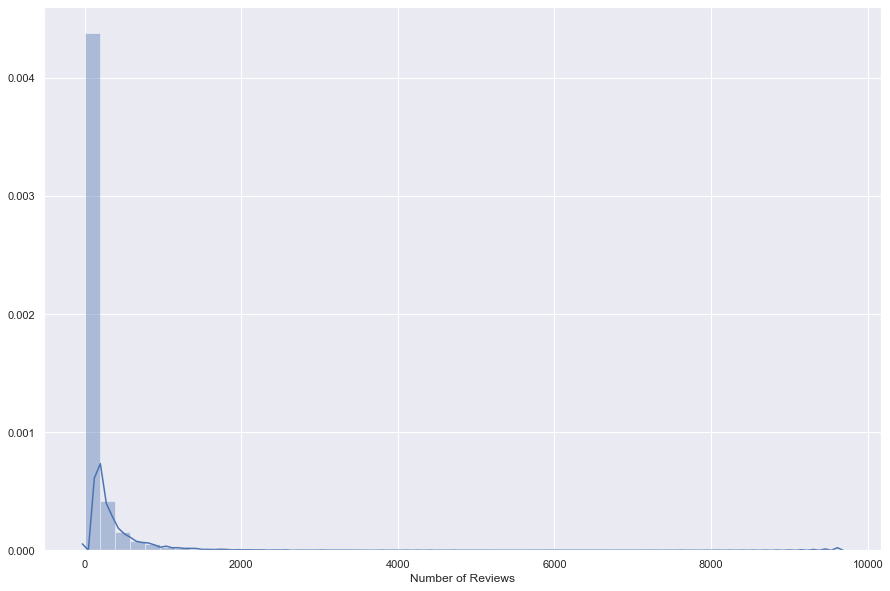

In [17]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.distplot(df['Number of Reviews'])

Видно что гистограмма сильно смещена, давайте посмотрим сколько значений больше 1000, и заменим их на 1000

In [18]:
sum(df['Number of Reviews']>1000)

673

In [19]:
df['Number of Reviews'] = df['Number of Reviews']\
            .apply(lambda x: 1000 if x>1000 else x)


In [20]:
df['Number of Reviews'].describe()

count    40000.000000
mean       104.971000
std        191.352218
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       1000.000000
Name: Number of Reviews, dtype: float64

Видно что, среднее значение уменьшилось, давайте посмотрим теперь какие выбросы будут для этого признака

In [21]:
find_outliers('Number of Reviews')

[-140.0, 252.0]

Границы остались такие же, значит мы впринципе почти не изменили данные, и они всё ещё могут строить правдивую модель

'Price Range'

In [22]:
df['Price Range'].isna().sum()

13886

In [23]:
df['Price Range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

В этом столбце очень много пропусков, поэтому присвоим значениям определенные числа, а пропуски заменим на 0

In [24]:
price_dict = {'$$ - $$$': 2,'$$$$': 3, '$': 1}
df['Price Range'] = df['Price Range'].map(price_dict)

Создадим отдельный признак с пропущенными значениями

In [25]:
df['Price Range NAN'] = pd.isna(df['Price Range']).astype('uint8')

In [26]:
df['Price Range'].fillna(0, inplace=True)

In [27]:
df['Price Range'].unique()

array([2., 0., 3., 1.])

'ID_TA'

In [28]:
df['ID_TA'].value_counts()

d9802625     2
d987900      2
d7337366     2
d11999956    2
d2477531     2
            ..
d10717093    1
d1067164     1
d2017215     1
d7051515     1
d5980819     1
Name: ID_TA, Length: 39980, dtype: int64

In [29]:
df['ID_TA'].isna().sum()

0

В данном признаке повторяются идентификаторы. Этих значений мало, однако они присутствуют, давайте посмотрим на них поближе

In [30]:
sum(df['ID_TA'].value_counts()>1)

20

Вернёмся к Restaurant_id, посмотрим сколько там повторяющихся элементов

In [31]:
sum(df['Restaurant_id'].value_counts()>1)

7204

Очень много одинаковых заведений в датасете.

In [32]:
df_TA_ID_ununique = df[df['ID_TA'].map(df['ID_TA'].value_counts()>1)]

In [33]:
df_TA_ID_ununique['ID_TA'].value_counts()

d987900      2
d9877640     2
d4600226     2
d11921719    2
d9802625     2
d11698990    2
d7342803     2
d3685055     2
d7809594     2
d1315077     2
d2477531     2
d11999956    2
d3161682     2
d8753348     2
d11674463    2
d697406      2
d13002276    2
d10047799    2
d7337366     2
d793170      2
Name: ID_TA, dtype: int64

У таких строк совпадают все значения кроме Restaurant_id и Ranking, Ranking и Restaurant_id линейно зависимы(corr-->1).

In [34]:
for i in df_TA_ID_ununique['ID_TA'].value_counts().index[:3]:
    display(df[df['ID_TA']==i])

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number of Reviews NAN,Price Range NAN
8019,2361.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,4.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900,0,0
22998,2312.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,4.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900,0,0


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number of Reviews NAN,Price Range NAN
15295,475.0,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",476.0,4.5,2.0,67.0,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640,0,0
15565,530.0,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",531.0,4.5,2.0,67.0,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640,0,0


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number of Reviews NAN,Price Range NAN
147,4110.0,Madrid,['Spanish'],4112.0,5.0,0.0,2.0,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226,0,1
9446,4104.0,Madrid,['Spanish'],4106.0,5.0,0.0,2.0,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226,0,1


Получается, что рестораны с абсолютно одинаковыми признаки, имеют разный Ranking, поэтому нужно присвоить одно значение для такого заведения.

In [35]:
for i in df_TA_ID_ununique['ID_TA'].value_counts().index:
    min_df = df[df['ID_TA']==i].Ranking
    min_rang = min_df.values.min()
    id_ = min_df.index.values
    df.loc[id_,'Ranking'] = min_rang

В колонке ID_TA уберём первый символ 'd' и преобразуем строку в int

In [36]:
df.ID_TA = df.ID_TA.apply(lambda x: int(x[1:]))

In [37]:
df.isna().sum()

Restaurant_id               0
City                        0
Cuisine Style            9283
Ranking                     0
Rating                      0
Price Range                 0
Number of Reviews           0
Reviews                     0
URL_TA                      0
ID_TA                       0
Number of Reviews NAN       0
Price Range NAN             0
dtype: int64

'URL_TA'

Возьмём координаты ресторана, и расстояние его от центра города. Так же для пропущенных строк в 'Cuisine Style' впишем туда кухни, которые запарсим

In [38]:
df['URL_TA'][0]

'/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html'

URL состоит из двух частей: 1)число,которое идёт после буквы 'g' - это город
2)число, которе идёт после буквы 'd' - совпадает со значением в столбце ID_TA
Отделим код города и запишем в новый столбец, т.к. этот ещё нам пригодится.

In [39]:
df['code_city'] = df['URL_TA'].apply(lambda x: float(x[20:26]))

'Cuisine Style'

In [40]:
type(df['Cuisine Style'][0])

str

В столбце много пропусков, вынесем их в отдельный признак, затем возьмём с сайта для каждого ресторана тип кухни,чтобы заполнить пропуски, если таковые останутся, то решим. Так же нужно сделать список кухонь, а не строку с кухнями

In [41]:
def create_list(item):
    """Создаёт список из строки."""
    
    if type(item) == str:
        return item.replace('[','').replace(']','').replace(" '",'').replace("'",'').split(',')
        
    else: return item

In [42]:
df['Cuisine Style NAN'] = df['Cuisine Style'].isna().astype('uint8')

In [43]:
df['Cuisine Style'] = df['Cuisine Style'].apply(create_list)

Возьмём список из уникальные значений кухонь для парсинга

In [44]:
new_list = []
for i in df['Cuisine Style']:
    if type(i)==list:
        new_list+=i
unique_cuisine = set(new_list)

In [45]:
# Здесь мы создаем список из значений типов кухни, которые мы взяли из unique_cuisine, и которые 
# нашлись на самих сайтах. Сделаем так, чтобы все слова начинались с заглавных букв.
eng_cuisines =['American', 'Irish', 'Italian', 'Bangladeshi', 'International', 'Native', 'Egyptian', 
'Vegan Options', 'Persian', 'Venezuelan', 'Delicatessen', 'South American',  'Spanish', 'Latin', 'Ecuadorean', 
'Ukrainian', 'Israeli','Mongolian', 'Azerbaijani', 'Danish', 'Peruvian', 'Sri Lankan', 'Latvian', 
'Scottish', 'Swiss', "Central Asian", 'Chilean', 'Brazilian', 'Pub', 'Armenian', 'Singaporean', 'Canadian', 
'New Zealand', 'Contemporary',  'Central European', 'Nepali', 'Greek', 'Fujian', 'Vietnamese', 'Thai', 
'Hawaiian', 'Polish', 'Cuban', 'Diner', 'Jamaican', 'Mexican', 'European', 'Caribbean', 'Caucasian', 'Asian', 
               'Indian', 'Czech', 'Hungarian', 'Welsh', 'Norwegian', 'Chinese', 'Romanian', 'Japanese', 'Tunisian',
               'Dutch', 'Halal', 'Cambodian', 'Portuguese', "Central American", 'Brew Pub', 'Arabic', 'Scandinavian',
               'Fusion', 'Argentinean', 'Russian', 'Burmese', 'Afghani', 'Belgian', 'Eastern European',
               'Gluten Free Options', 'Salvadoran', 'Turkish', 'Taiwanese', 'Pakistani', 'Yunnan', 'Austrian',
               'Southwestern', 'Filipino', 'Australian', 'Swedish', 'Colombian', 'Croatian', 'Healthy',
               'Malaysian', 'Pizza', 'Albanian', 'Balti', 'Kosher', 'Grill', 'Uzbek', 'Gastropub', 'Xinjiang',
               'Cafe', 'Polynesian', 'Mediterranean', 'Moroccan', 'Sushi', 'Georgian', 'Steakhouse', 'German',
               'Barbecue', 'Korean', "Street Food", 'Lebanese', "Vegetarian Friendly", 'Slovenian', 'Bar', 
               'African', 'Indonesian', 'Tibetan', 'Ethiopian', 'Seafood', "Fast Food", 'British', 
               'Cajun & Creole', 'Soups', 'French', 'Middle Eastern']

for k,i in enumerate(eng_cuisines):
    eng_cuisines[k] = i.title()

In [46]:
# Список с такими же словами только на русском языке, делаем так из-за того, что я не смог собрать данные на английском языке
# не получилось в requests.get() передать параметр headers со значением Accept-Language: en. Ошибки не было, но данные
# приходили на русском языке, пришлось заморочиться и сделать вот такой список.
rus_cuisines = ['Американская', 'Ирландская', 'Итальянская', 'Бангладешская', 'Международная', 'Индейская', 'Египетская',
"Для веганов", 'Персидская', 'Венесуэльская', 'Гастроном', 'Южноамериканская', 'Испанская', 'Латинская', 'Эквадорская',
'Украинская', 'Израильская', 'Монгольская', 'Азербайджанская', 'Датская', 'Перуанская', 'Шриланкийская', 'Латышская', 
'Шотландская', 'Швейцарская', 'Среднеазиатская', 'Чилийская','Бразильская', 'Паб', 'Армянская', 'Сингапурская', 'Канадская',
'Новозеландская', 'Современная', 'Центральноевропейская', 'Непальская', 'Греческая', 'Фуцзянь', 'вьетнамская', 'Тайская', 
'Гавайская', 'Польская', 'Кубинская', 'Закусочная', 'Ямайская', 'Мексиканская', 'Европейская', 'Карибская', 'Кавказская', 'Азиатская', 
'Индийская', 'Чешская', 'Венгерская', 'валлийская', 'Норвежская',  'Китайская', 'румынская', 'Японская',
'Тунисская', 'Голландская', 'Халяль', 'Камбоджийская', 'португальская', 'Центральноамериканская', 'Паб с пивоварней', 
'арабская', 'Скандинавская', 'Фьюжн', 'Аргентинская', 'русская', 'Бирманская', 'Афганская', 'бельгийская',
'Восточноевропейская', 'Безглютеновые блюда', 'Сальвадорская', 'турецкая','Тайваньская', 'Пакистанская', 'Юньнаая', 
'Австрийская', 'Югозападная', 'Филиппинская', 'Австралийская', 'Шведская', 'Колумбийская', 'хорватская', 'Здоровая',
                'Малазийская', 'Пицца', 'албанская', 'Балти', 'Кошерная', 'Гриль', 'Узбекская', 'Гастропаб', 'Синьцзян', 
                'Кафе', 'Полинезийская', 'Средиземноморская', 'Марокканская', 'Суши', 'Грузинская', 'Стейк-хаус',
                'Немецкая', 'Барбекю', 'Корейская', "Уличная еда",  'Ливанская', "Подходит для вегетарианцев", 
                'словенская', 'Бар', 'Африканская', 'индонезийская', 'тибетская', 'Эфиопская', 'Морепродукты',
                'Фастфуд','Британская', "Каджунская и креольская", 'Супы', 'Французская', 'Ближневосточная']


for k,i in enumerate(rus_cuisines):
    rus_cuisines[k] = i.title()

In [47]:
# Создаём словарь с ключами rus_cuisines и соответствующими значениями из eng_cuisines
dict_cuisines = dict.fromkeys(rus_cuisines)
for k,i in enumerate(dict_cuisines):
    dict_cuisines[i] = eng_cuisines[k]

In [48]:
# Эти функции я оставлю здесь но выполню их в другом ноутбуке, а сюда вставлю только результат выполнения.

def get_html(item):
    '''Функция выводит список из типов кухни для url из URL_TA.
    Т.к. сайт очень объемный, он долго считывает инфу, для ~1/4 данных датасета
    придётся подождать примерно 5 часов.'''
    url = 'https://www.tripadvisor.ru' + item
    response = requests.get(url, headers={"Accept-Language": "en",'User-Agent': UserAgent().chrome}).text
    page = Bs(response,'html.parser')
    list_of_names = page.find_all('div', class_ = '_14zKtJkz')
    if len(list_of_names)>0:
        for ind,i in enumerate(list_of_names):
            if i.text=='ТИП КУХНИ':
                return page.find_all(class_='_1XLfiSsv')[ind].text.replace(' ','').split(',')
            
            
def rus_to_eng(item):
    '''Заменяет русские слова на английские'''
    item2 = []
    if type(item)==float:
        return nan
    elif type(item)==list:
        for k in range(0,len(item)):
            if item[k] in dict_cuisines:
                item2.append(dict_cuisines[item[k]])
        return item2

In [49]:
%%time
# Чтобы убедиться, что функция работает, выполню её для 5 строк.
df[df['Cuisine Style'].isna()]['URL_TA'][0:5].apply(get_html)

Wall time: 9.58 s


1             [Азиатская, Непальская]
3                                None
5     [Португальская, Бар, Винныйбар]
8                 [Кафе, Европейская]
10     [Испанская, Средиземноморская]
Name: URL_TA, dtype: object

In [50]:
# Открываем эту таблицу, в которую записали результат работы по сбору данных с сайта
parsing_cuisines = pd.read_csv('parsing_cuisine.csv',encoding='windows-1251').Cuisine

In [51]:
# Возьмём список индексов пропущенных значений в Cuisine Style, т.к. в parsing_cuisines индексы идут по порядку.
indexies = df[df['Cuisine Style'].isna()].index.tolist()
parsing_cuisines.index = indexies


Приведём строку к списку

In [52]:
parsing_cuisines = parsing_cuisines.apply(create_list)

Посмотрим на уликальные названия кухонь в типах кухонь, которые мы взяли с сайта.
Сравним с кухнями, которых нет в исходном датасете, после этого попытаемся их преобразовать в нужный формат.

In [53]:
unique_list = []
for i in parsing_cuisines:
    if type(i)==list:
        for k in i:
            unique_list.append(k)
unique_list = list(set(unique_list))

In [54]:
# Кухни которых нет в исходном датасете.
for i in unique_list:
    if i not in dict_cuisines:
        print(i)

Центральноазиатская
Романья
Пивныерестораны
Сицилийская
Барысрестораном
КухняЛомбардии
Римская
Латиноамериканская
КухняЛацио
Японскаякухня-фьюжн
Тосканская
Каталанская
Уличнаяеда
Центрально-итальянская
Фруктовыесалоны
Каджунскаяикреольская
Пабспивоварней
Неаполитанская
Стейк-хаус
Северно-итальянская
Южно-итальянская
КухняКампании
Винныйбар
Юговосточная
КухняЭмилии-Романьи


In [55]:
# Преобразуем кухни, которые немного не так были записаны на сайте.
def replace_parsing_cuisine(item):
    replace_dict = {'Стейк-хаус':'Стейк-Хаус',
            'Винныйбар':'Бар',
            'Уличнаяеда': 'Уличная Еда',
            'Фруктовыесалоны': 'Фруктовые Салоны',
            'КухняЛомбардии':'Итальянская',
            'Центрально-итальянская': 'Итальянская',
            'Романья':"Итальянская",
            'Римская':"Итальянская",
            'Северно-итальянская': 'Итальянская',
            "Пабспивоварней": "Паб С Пивоварней",
            "Южно-итальянская": "Итальянская",
            "Барысрестораном": "Бар",
            'Японскаякухня-фьюжн': "Фьюжн",
            "Каталанская": 'Испанская',
            "КухняЛацио": "Итальянская",
            "КухняЭмилии-Романьи": "Итальянская",
            "Пивныерестораны": "Паб С Пивоварней",
            "Каджунскаяикреольская":"Каджунская И Креольская",
            "Юговосточная":'Ближневосточная',
            "Неаполитанская":"Итальянская",
            "Центральноазиатская":"Азиатская"}
    if type(item)==list:
        for i in range(0,len(item)):
            if item[i] in replace_dict:
                item[i] = replace_dict[item[i]]
    if type(item)==list:
        return list(set(item))
    else: return item

In [56]:
parsing_cuisines = parsing_cuisines.apply(replace_parsing_cuisine)

In [57]:
parsing_cuisines[:10]

1                      [Непальская, Азиатская]
3                                          NaN
5                         [Бар, Португальская]
8                          [Европейская, Кафе]
10              [Средиземноморская, Испанская]
21                                         NaN
26                            [Испанская, Бар]
27                                         NaN
28                                         NaN
29    [Паб, Бар, Испанская, Средиземноморская]
Name: Cuisine, dtype: object

In [58]:
# Заменим кухни с русского на аншл, как в исходном датасете
parsing_cuisines = parsing_cuisines.apply(rus_to_eng)

In [59]:
parsing_cuisines

1                 [Nepali, Asian]
3                             NaN
5               [Bar, Portuguese]
8                [European, Cafe]
10       [Mediterranean, Spanish]
                   ...           
39981                         NaN
39983                         NaN
39986                         NaN
39988                         NaN
39993                         NaN
Name: Cuisine, Length: 9283, dtype: object

In [60]:
# соединим списки кухонь
df['Cuisine Style'] = df['Cuisine Style'].combine_first(parsing_cuisines)

In [61]:
# По итогу мы заполнили ~половину пропусков в этом признаке

In [62]:
df['Cuisine Style'].isna().sum()

4846

In [63]:
# Выпешем пропуски в отдельный признак
df['Cuisine Style NAN'] = pd.isna(df['Cuisine Style']).astype('uint8')

In [64]:
# Заполним пропуски списком из слова Other
x=[]
for i in df['Cuisine Style']:
    if type(i)==list:
        x.append(i)
    elif type(i)==float:
        x.append(['Other'])
df['Cuisine Style'] = x

In [65]:
# Добавим признак кол-во кухонь в ресторане
df['number_of_cuisines'] = df['Cuisine Style'].apply(lambda x: len(x))

'Reviews'

В колонке есть отзывы о заведении и время их отправки, давайте вытащим из данных время, а затем поработаем с самими отзывами

In [66]:
# 6471 пустое значение
df.Reviews.value_counts()[:10]

[[], []]                                                                                                                              6471
[['Sat night', 'Can\'t even explain.. "A" place.. A "100...'], ['10/22/2017', '05/11/2017']]                                             2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]                                           2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                                                  2
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                                                      2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                                                  2
[['Great Food! Wide Variety.', 'Dinner'], ['11/26/2017', '05/23/2017']]                                                                  2
[['The real codido madrileñ

In [67]:
df['date'] = df['Reviews'].apply(lambda x: [0] if pd.isna(x) else x[2:-2].\
                    split('], [')[1][1:-1].split("', '"))

Добавим признак, который обозначает разницу между отзывами

In [68]:
df['diff_date'] = df['date'].apply(lambda x: None if x == [] else pd.to_datetime(x).max() - pd.to_datetime(x).min())

In [69]:
df['diff_date'] = df[~df['diff_date'].isna()]['diff_date'].apply(lambda x: None if pd.isna(x) else int((str(x).split(' ')[0])))

In [70]:
df['diff_date'].describe()

count    33529.000000
mean       122.455993
std        211.247868
min          0.000000
25%          8.000000
50%         49.000000
75%        147.000000
max       3207.000000
Name: diff_date, dtype: float64

In [71]:
# Находим верхнюю границу выбросов
upper_outlier = find_outliers('diff_date')[1]
upper_outlier

355.5

In [72]:
# Кол-во элементов, которые выходят за эту границу
len(df[df.diff_date>upper_outlier])

2779

In [73]:
df['diff_date']

0          41.0
1         382.0
2           2.0
3           NaN
4         272.0
          ...  
39995      34.0
39996       9.0
39997    3127.0
39998      23.0
39999    1306.0
Name: diff_date, Length: 40000, dtype: float64

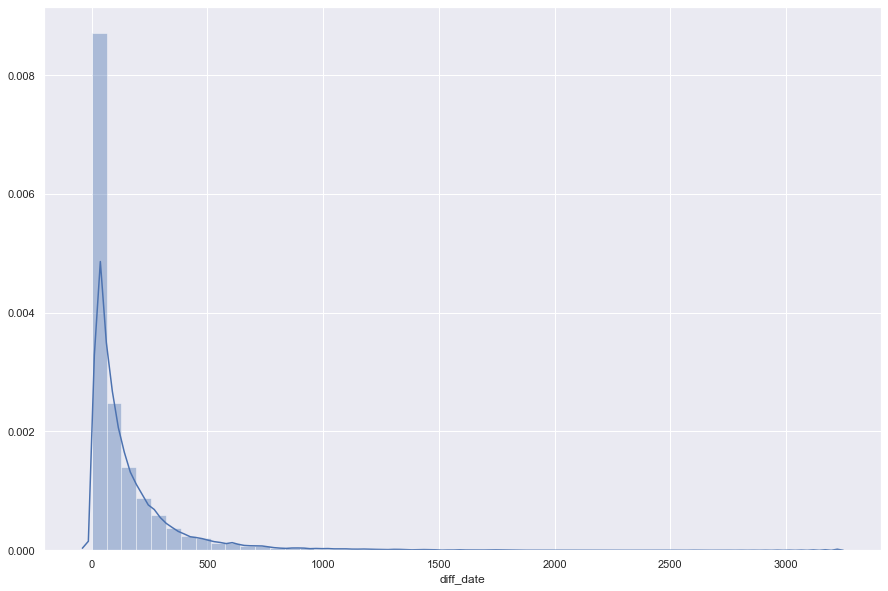

In [74]:
sns.distplot(df['diff_date'])

По графику видно, что много значений в районе 0, поэтому медиана сместилась ближе к этим значениям, можем считать что по графику выбросами будут значения, которые больше 1150, посмотрим сколько таких значений

In [2448]:
len(df[df.diff_date>1150])

263

Заменим все значения, которые больше 1150 на 1150

In [2449]:
df[~df.diff_date.isna()].diff_date = df[~df.diff_date.isna()].diff_date.apply(lambda x: 1150 if x>1150 else x)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [2450]:
df.diff_date.isna().sum()

6471

В столбце много пропусков, поэтому заменим их на медиану.

In [2451]:
df.diff_date = df.diff_date.fillna(df.diff_date.median())

Добавим признак: кол-во дней с настоящего момента до времени последнего комментария

In [2452]:
df['days_from_now'] = df['date'].apply(lambda x: None if x==[] else pd.datetime.now() - pd.to_datetime(x).max())

<ipython-input-2452-9a025cbdc135>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['days_from_now'] = df['date'].apply(lambda x: None if x==[] else pd.datetime.now() - pd.to_datetime(x).max())


In [2453]:
df['days_from_now'] = df['days_from_now'].apply(lambda x: x.days)

In [2454]:
df['days_from_now'].isna().sum()

6471

Заполним пропуски средним значением

In [2455]:
df['days_from_now'] = df['days_from_now'].fillna(df['days_from_now'].mean())

В Reviews, оставим только отзывы, которые разделим по словам, чтобы создать новый признак, отличающий положительный комментарий от негативного

In [2456]:
df['Reviews'] = df['Reviews'].apply(lambda x: x.split(']')[0].lower().replace('[','').replace("'",'').replace(',','').split(' '))

0        [['Good food at your doorstep', 'A good hotel ...
1        [['Unique cuisine', 'Delicious Nepalese food']...
2        [['Catch up with friends', 'Not exceptional'],...
3                                                 [[], []]
4        [['Best place to try a Bavarian food', 'Nice b...
                               ...                        
39995    [['The real Italian experience!', 'Wonderful f...
39996    [['Parisian atmosphere', 'Bit pricey but inter...
39997    [['Good by swedish standards', 'A hidden jewel...
39998    [['Underground restaurant', 'Oldest Restaurant...
39999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 40000, dtype: object

Выгрузим из .txt файлов положительные и негативные слова

In [2457]:
bad_words = []
f = open('end_neg_words.txt', 'r')
for line in f:
    line.replace(' ','')
    bad_words.append(line[:-1])

In [2458]:
good_words = []
f = open('end_pos_words.txt', 'r')
for line in f:
    line.replace(' ','')
    good_words.append(line[:-1])

In [2459]:
def bad_review_score(item):
    """Считает кол-во отрицательных и положительных слов в отзыве."""
    k=0
    for word in item:
        if word in bad_words:
            k+=1
    return k

def good_review_score(item):
    k=0
    for word in item:
        if word in good_words:
            k+=1
    return k

In [2460]:
df['bad_review_score'] = df['Reviews'].apply(bad_review_score)
df['good_review_score'] = df['Reviews'].apply(good_review_score)


Визуализируем данные

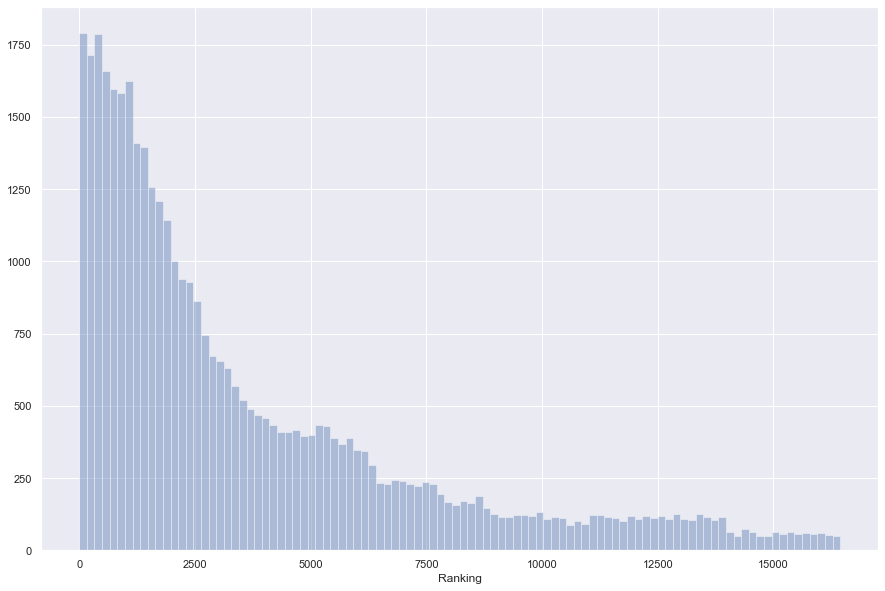

In [2461]:
#Видно что большинство заведений смещены к наименьшему рейтингу,т.к. не везде есть так много рестаранов,
# и может быть в сборе данных были допущены какие-то ошибки, и проставились не те числа
sns.distplot(df['Ranking'], kde=False, bins=100)

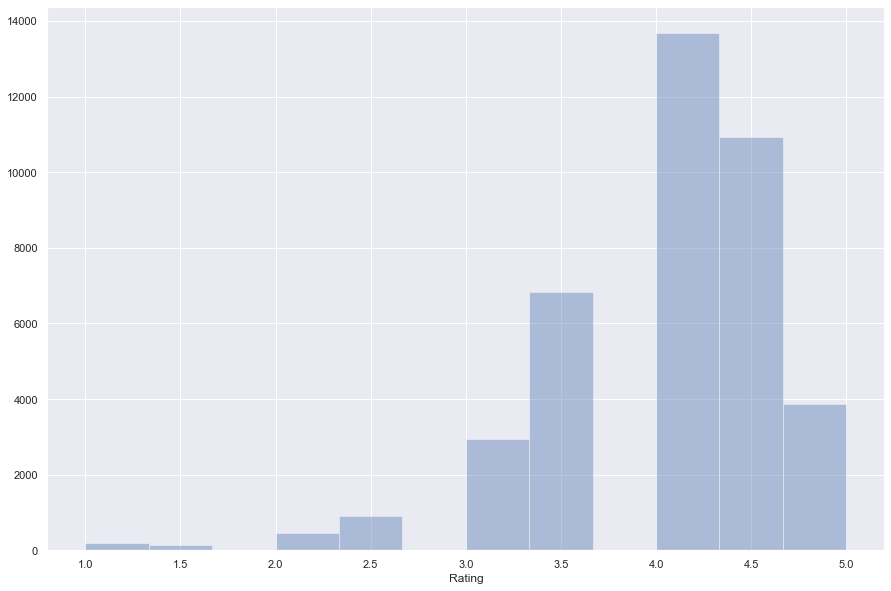

In [2462]:
#Из графика видно, что очень мало заведений с низкой оценкой
sns.distplot(df['Rating'], kde=False, bins=12)

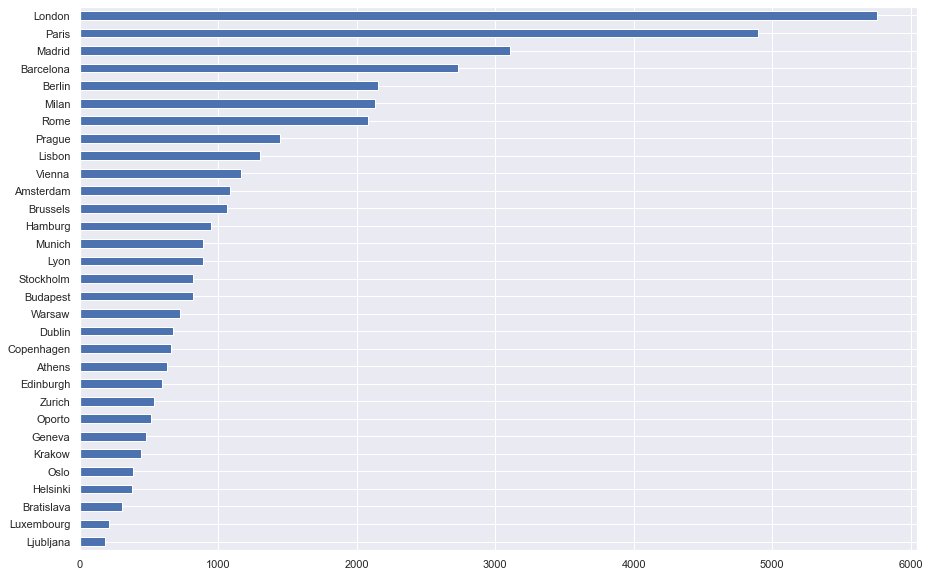

In [2463]:
#Видно, что кол-во одинаковых городов в таблице меньше, чем самые большие числа в признаке Ranking,
# скорее всего, взяли просто не все заведения, которые есть из городов,
df['City'].value_counts(ascending=True).plot(kind='barh')

Глянем подробнее на признак Ranking

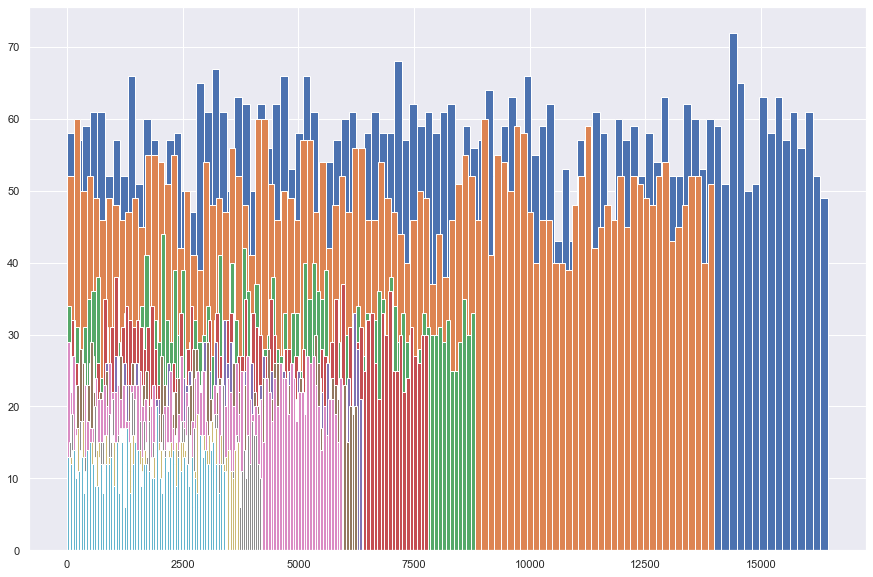

In [2464]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)


Впринципе всё распределено нормально, чем больше одного города в датасете, тем больше Ranking.

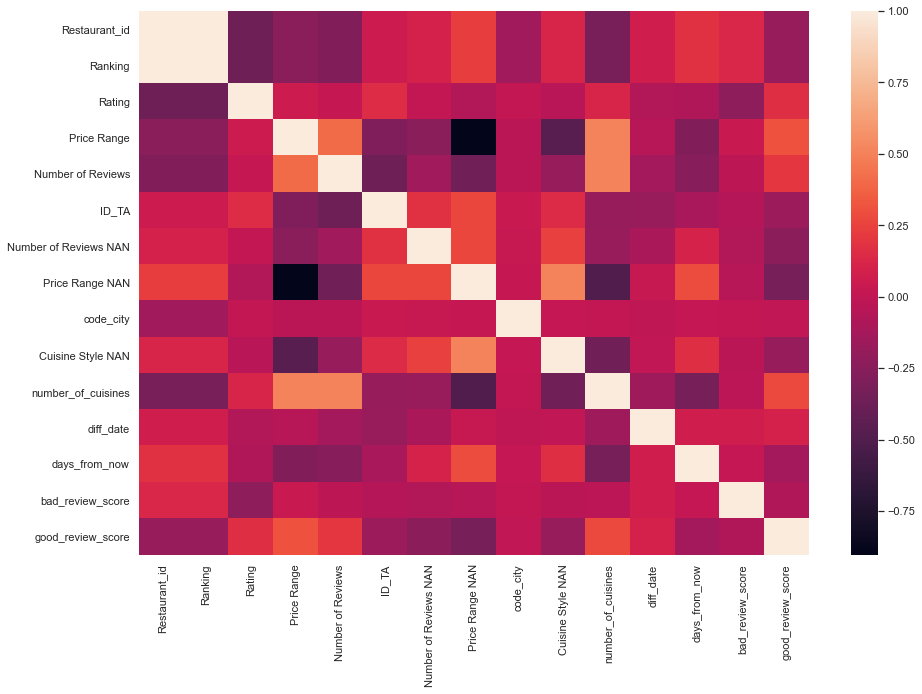

In [2465]:
sns.heatmap(df.corr())

Из тепловой карты видно, сильнее всего выделяются признаки Price Range - Price Range NAN, number_of_cuisines - top_10_cuisines,
Ranking-Restaurant_id

Соберём координаты каждого заведения в датасете

In [2466]:
from multiprocessing.dummy import Pool as ThreadPool # Чтобы использовать несколько потоков при парсинге.
def get_coords(url):
    '''Принимает html страницу, переводит в str и находит координаты,
    затем выводит список из двух элементов [ширина,долгота]'''
    print(url)
    url = 'https://www.tripadvisor.ru' + url
    pattern = re.compile('coords".?.?\d+.?\d+.?.?\d+.?\d+')
    response = requests.get(url, headers={'User-Agent': UserAgent().chrome}).text
    page = Bs(response,'html.parser')
    if len(page.find_all('div', id="RESTAURANT_SEARCH_BTN"))==0:
        try:
            return pattern.findall(str(page))[0]
        except indexError:
            return url
    else: 
        return nan

In [2467]:
# Прочтём координаты из файла, который записали ранее в другом ноутбуке, запишем в список
coords = []
f = open('coords.txt', 'r')
for line in f:
    coords.append(line[:-1])
f.close()

In [2468]:
# используя класс geopy, найдём координы всех городов, которые встречаются в датасете.
# запишем данные в словарь, где ключ - это город, а координаты - значение.

coords_dict = {}
geolocator = Nominatim(user_agent="geoapiExercises")

for city in df['City'].unique():
    print('Записали координаты:',city)
    location = geolocator.geocode(city)
    coords_dict[city] = (location.latitude, location.longitude)

Записали координаты: Paris
Записали координаты: Stockholm
Записали координаты: London
Записали координаты: Berlin
Записали координаты: Munich
Записали координаты: Oporto
Записали координаты: Milan
Записали координаты: Bratislava
Записали координаты: Vienna
Записали координаты: Rome
Записали координаты: Barcelona
Записали координаты: Madrid
Записали координаты: Dublin
Записали координаты: Brussels
Записали координаты: Zurich
Записали координаты: Warsaw
Записали координаты: Budapest
Записали координаты: Copenhagen
Записали координаты: Amsterdam
Записали координаты: Lyon
Записали координаты: Hamburg
Записали координаты: Lisbon
Записали координаты: Prague
Записали координаты: Oslo
Записали координаты: Helsinki
Записали координаты: Edinburgh
Записали координаты: Geneva
Записали координаты: Ljubljana
Записали координаты: Athens
Записали координаты: Luxembourg
Записали координаты: Krakow


In [2469]:
#с помощью pd.Series.map создадаим признак, с координатами городов
df['Coord_city'] = df['City'].map(coords_dict)

In [2470]:
df['Coord_restaurant'] = coords

In [2471]:
#Исправим ошибки в стоках и обработаем их для нужного нам формата
def coords_to_float(item):
    try:
        if item=='NAN':
            return nan
        elif 'coords":"' in item:
            item = item.replace('coords":"','')
            return item
        elif '[' in item:
            return item.replace('[','').replace(']','')[1:-1]
        elif item=='52 27m 22.9212s N, 13 24m 1.27898e-12s E':
            return '52.4504748,13.3699209'
    
        elif item=='nan':
            return nan
        else: return item.replace('(','').replace(')','')
    except:
        return nan

In [2472]:
df['Coord_restaurant'] = df['Coord_restaurant'].apply(coords_to_float)

В столбце Coord_restaurant пропуски из-за того, что ссылки были даны не на ресторан, а на список из нескольких ресторанов, поэтому координаты было никак не взять.

In [2473]:
# найдём расстояния для ненулевых строк в км.
distance_list = []
for index in range(0,df.shape[0]):
    if (type(df.loc[index,'Coord_restaurant'])==tuple) or (type(df.loc[index,'Coord_restaurant'])==str):
        pt1 = geopy.Point(df.loc[index,'Coord_city'])
        pt2 = geopy.Point(df.loc[index,'Coord_restaurant'])
        distance_list.append(geopy.distance.distance(pt1, pt2).km)
    elif (type(df.loc[index,'Coord_restaurant'])==float):
        distance_list.append(nan)

In [2474]:
df['Distance'] = distance_list

Заменим пропуски в Distance на среднее

In [2475]:
# В столбце есть выбросы, это связано, с тем, что при парсинге координат, у записей на сайте не было структуры,
# поэтому собирались другие координаты, следовательно некоторые значения получились такими.
df['Distance'].max()

6759.376360550523

In [2487]:
df[df['Distance']==df['Distance'].max()]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number of Reviews NAN,Price Range NAN,code_city,Cuisine Style NAN,number_of_cuisines,date,diff_date,days_from_now,bad_review_score,good_review_score,Coord_city,Coord_restaurant,Distance,squares
8756,12626.0,Paris,[French],12628.0,3.0,0.0,0.0,"[not, good!]",/Restaurant_Review-g187147-d5928000-Reviews-Ch...,5928000,1,1,187147.0,0,1,[08/11/2017],0.0,1293.0,0,0,"(48.8566969, 2.3514616)","16 14m 40.308s N, 61 32m 0.744s W",6759.376361,105.4


я перешёл на гугл карты, которые были указаны на странице заведения. И там видимо была какая-то ошибка, т.к. в таблице указан Париж, а геолокация показывает остров рядом с Доминикана, т.к. удалять значения нельзя, я заменю все слишком большие значение на среднее.

Создадим словарь с площадями городов, если Distance будет больше площади города, то это 100% ошибка, посмотрим сколько таких ошибок

In [2477]:
df['City'].unique().tolist()

['Paris',
 'Stockholm',
 'London',
 'Berlin',
 'Munich',
 'Oporto',
 'Milan',
 'Bratislava',
 'Vienna',
 'Rome',
 'Barcelona',
 'Madrid',
 'Dublin',
 'Brussels',
 'Zurich',
 'Warsaw',
 'Budapest',
 'Copenhagen',
 'Amsterdam',
 'Lyon',
 'Hamburg',
 'Lisbon',
 'Prague',
 'Oslo',
 'Helsinki',
 'Edinburgh',
 'Geneva',
 'Ljubljana',
 'Athens',
 'Luxembourg',
 'Krakow']

In [2478]:
list_of_sq = [105.4,188,1572,891.8,310,41.42,181.8,367.6,414.6,1285,101.9,604.3,117.8,
              32.61,87.88,517.2,525.5,88.25,219.3,47.87,755.2,100,
                496,454,213.8,264,15.93,163.8,38.96,2586,327]

In [2479]:
squares_dict = {}
k=0
for city in df['City'].unique().tolist():
    squares_dict[city]=list_of_sq[k]
    k+=1

In [2480]:
df['squares'] = df['City'].map(squares_dict)

In [2491]:
df[df['Distance']>df['squares']].shape

(13, 24)

заменим их на mean

In [2494]:
for i in df[df['Distance']>df['squares']].index.tolist():
    df.loc[i,'Distance'] = df['Distance'].mean()

In [2495]:
df['Distance'].mean()

3.878734744669208

Заменим пропуски на mean

In [2496]:
df[df['Distance'].isna()] = df[df['Distance'].isna()].fillna(df['Distance'].mean())

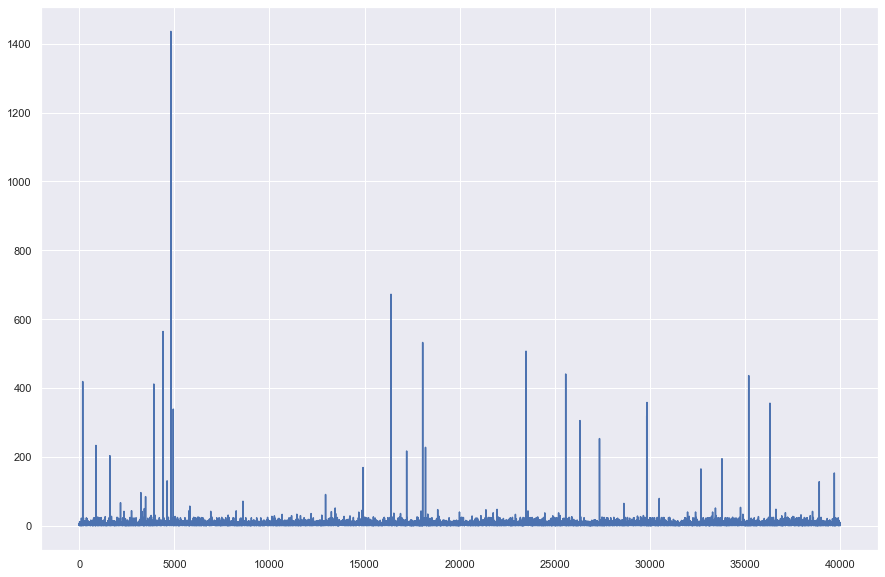

In [2497]:
df['Distance'].plot()

In [2499]:
# признак население (по информации из Википедии)

population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

df['population'] = df.City.map(population)


In [2500]:
# Признак - индекс покупательской способности согласно рейтингу Numbeo (2018)

purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

df['purchasing_power'] = df.City.map(purchasing_power_index)


In [2501]:
# Добавим признак кол-ва ресторанов в городе

number_of_rest_city = df.groupby('City')['Ranking'].count().to_dict()
df['rest_city_count'] = df.City.map(number_of_rest_city)

In [2502]:
# Добавим признак относительного ранга ресторана по городу

df['city_ranking'] = df.Ranking / df.rest_city_count

In [2503]:
# ранг ресторана на основании кол-ва отзывов

df['ranking_rev_count'] = df.Ranking * df['Number of Reviews']

In [2504]:
# соотношение кол-ва отзывов и населения города

df['reviews_per_city_pop'] = df['Number of Reviews'] / df.population

In [2505]:
# Максимальный ранг

ranking_max_per_city = df.groupby('City')['Ranking'].max()
df['rating_max_per_city'] = df.City.map(ranking_max_per_city)

In [2506]:
# Добавим признак туристическая привлекательность
tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

df['tourist_attract'] = df.City.map(tourist_attract)

In [2507]:
df = pd.get_dummies(df,columns=['Price Range','City'])


In [2508]:
#Признаки 'Cuisine Style NAN','bad_review_score','squares' ухудшили MAE

In [2509]:
X = df[['city_ranking', 'ranking_rev_count', 'Number of Reviews',
       'ID_TA','Ranking','days_from_now','Distance','reviews_per_city_pop','City_Barcelona', 
        'diff_date','Price Range_0.0', 'Price Range_1.0','code_city',
        'purchasing_power','rating_max_per_city','good_review_score',
        'Price Range_2.0', 'Price Range_3.0','tourist_attract','population',
        'City_Berlin', 'City_Bratislava', 'City_Brussels','rest_city_count',
        'City_Budapest', 'City_Copenhagen', 'City_Dublin', 'City_Edinburgh',
        'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow',
        'City_Lisbon', 'City_Ljubljana', 'City_London', 'City_Luxembourg',
        'City_Lyon', 'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto',
        'City_Oslo', 'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm',
        'City_Vienna', 'City_Warsaw', 'City_Zurich','City_Amsterdam', 'City_Athens']]
y = df['Rating']

In [2523]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
regr = RandomForestRegressor(n_estimators = 100)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [2524]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19714874999999998


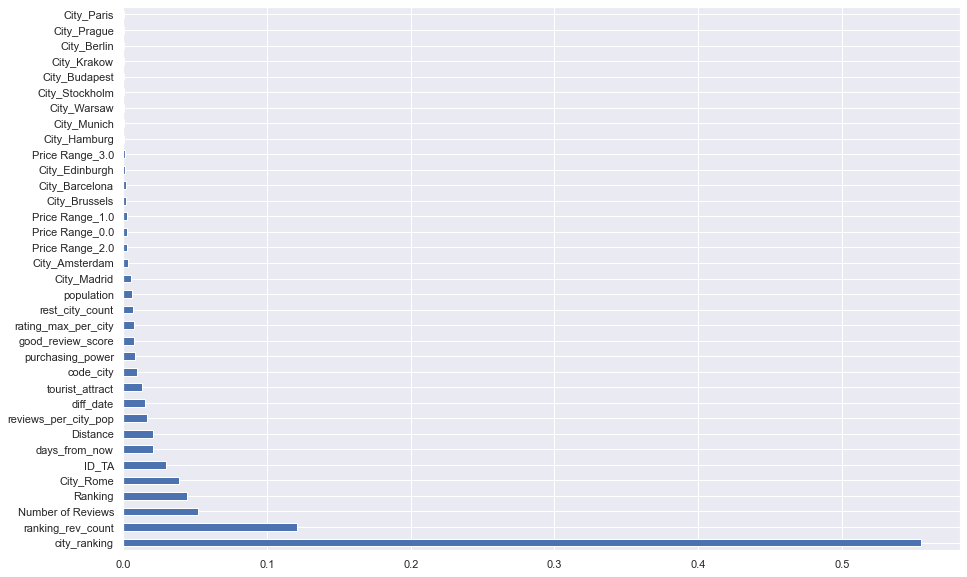

In [2512]:
(pd.Series(regr.feature_importances_, index=X.columns)
   .nlargest(35)
   .plot(kind='barh')) 

In [2513]:
# В ходе работы было использовано много сторонних данных, местоположения ресторанов, добавили новые кухни, так же
# добавили статистические данные из интернета